# Audio Classification

**Course:** CSCI 6366 - Neural Networks & Deep Learning  
**Team:**
- Shambhavi Adhikari (G37903602)
- Rakshitha Mamilla (G23922354)
- Abhiyan Sainju (G22510509)

---

**Dataset:** 610 mono WAV files (~1 second, 16 kHz)
- Dog: 210 samples
- Cat: 207 samples
- Bird: 193 samples

---

# PART 1: Data Exploration & Understanding

First, let's explore our dataset to understand the audio characteristics of each class.

---


In [1]:
# ============================================================================
# IMPORTS - All libraries needed for the entire notebook
# ============================================================================

# Core scientific computing
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
from pathlib import Path
from collections import Counter

# Audio processing
import librosa
import librosa.display
import soundfile as sf
import scipy.signal

# Deep learning frameworks
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models

# Machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score
)

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION - Global parameters and random seeds
# ============================================================================

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Audio parameters
SAMPLE_RATE = 16000  # 16 kHz sampling rate
N_FFT = 1024  # FFT window size
HOP_LENGTH = 512  # Number of samples between successive frames
N_MELS = 128  # Number of mel bands
N_MFCC = 40  # Number of MFCC coefficients
DURATION = 1.0  # Audio duration in seconds

# Dataset configuration
DATA_DIR = Path("../data").resolve()
CLASS_NAMES = ["dog", "cat", "bird"]
label_to_index = {label: idx for idx, label in enumerate(CLASS_NAMES)}

# Train/validation/test split ratios
TEST_SIZE = 0.15
VAL_SIZE = 0.15

# Transfer learning parameters
MAX_FRAMES = 100  # Fixed number of YAMNet embedding frames per clip

# ============================================================================
# DISPLAY CONFIGURATION
# ============================================================================

print("=" * 80)
print("🎵 AUDIO CLASSIFICATION PROJECT - FINAL SUBMISSION")
print("=" * 80)
print(f"\n📁 Data directory: {DATA_DIR}")
print(f"🔊 Sample rate: {SAMPLE_RATE} Hz")
print(f"📊 Mel bands: {N_MELS}")
print(f"🎯 Classes: {CLASS_NAMES}")
print(f"🔢 Label mapping: {label_to_index}")
print(f"✅ TensorFlow version: {tf.__version__}")
print(f"✅ Random seeds set for reproducibility")
print("=" * 80)


🎵 AUDIO CLASSIFICATION PROJECT - FINAL SUBMISSION

📁 Data directory: /Users/abhiyansainju/Desktop/GW Classes/Fall 2025/Neural Networks and Deep Learning CSCI_6366_80/Audio Classification/audio-classification-cnn/data
🔊 Sample rate: 16000 Hz
📊 Mel bands: 128
🎯 Classes: ['dog', 'cat', 'bird']
🔢 Label mapping: {'dog': 0, 'cat': 1, 'bird': 2}
✅ TensorFlow version: 2.20.0
✅ Random seeds set for reproducibility


In [2]:
dog_file = next((DATA_DIR / "dog").glob("*.wav"))
cat_file = next((DATA_DIR / "cat").glob("*.wav"))
bird_file = next((DATA_DIR / "bird").glob("*.wav"))

print("Dog example:", dog_file)
print("Cat example:", cat_file)
print("Bird example:", bird_file)
print("All exist?", dog_file.exists(), cat_file.exists(), bird_file.exists())


Dog example: /Users/abhiyansainju/Desktop/GW Classes/Fall 2025/Neural Networks and Deep Learning CSCI_6366_80/Audio Classification/audio-classification-cnn/data/dog/62581901_nohash_0.wav
Cat example: /Users/abhiyansainju/Desktop/GW Classes/Fall 2025/Neural Networks and Deep Learning CSCI_6366_80/Audio Classification/audio-classification-cnn/data/cat/e3e49931_nohash_0.wav
Bird example: /Users/abhiyansainju/Desktop/GW Classes/Fall 2025/Neural Networks and Deep Learning CSCI_6366_80/Audio Classification/audio-classification-cnn/data/bird/6a27a9bf_nohash_0.wav
All exist? True True True


In [3]:
# Count the number of audio files in each animal class
from collections import defaultdict

sample_count = defaultdict(int)
for class_name in CLASS_NAMES:
    class_dir = DATA_DIR / class_name
    files = list(class_dir.glob("*.wav"))
    sample_count[class_name] = len(files)
    print(f"Number of audio files for {class_name}: {len(files)}")



Number of audio files for dog: 210
Number of audio files for cat: 207
Number of audio files for bird: 193


Visualizing the Audio Waveform

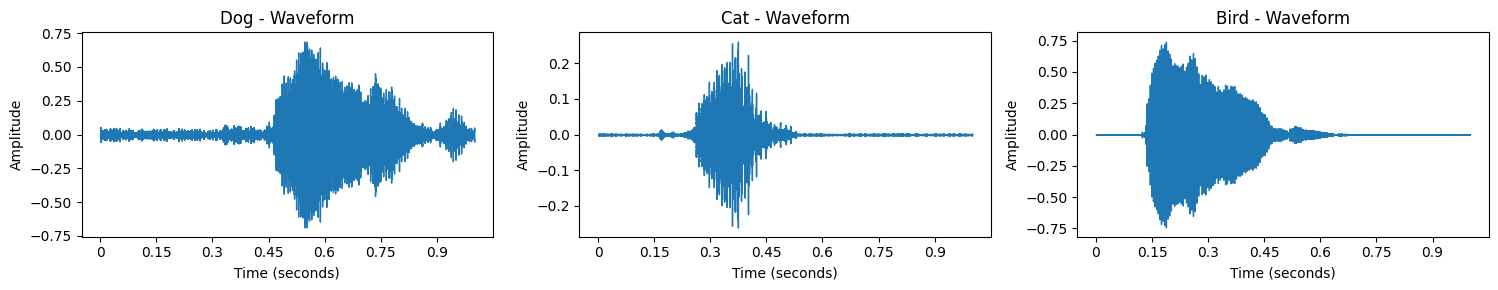

In [4]:
# Create waveform visualization for all three animals
# Use the example files defined in Cell 3: dog_file, cat_file, bird_file

example_files = {
    "dog": dog_file,
    "cat": cat_file,
    "bird": bird_file
}

fig, axs = plt.subplots(1, 3, figsize=(15, 3))
for idx, class_name in enumerate(CLASS_NAMES):
    path = example_files[class_name]
    if path is not None and path.exists():
        y, sr = librosa.load(path, sr=SAMPLE_RATE)
        librosa.display.waveshow(y, sr=sr, ax=axs[idx])
        axs[idx].set_title(f"{class_name.capitalize()} - Waveform")
        axs[idx].set_xlabel("Time (seconds)")
        axs[idx].set_ylabel("Amplitude")
    else:
        axs[idx].text(0.5, 0.5, "File Not Found", ha='center', va='center')
        axs[idx].set_title(f"{class_name.capitalize()} - Waveform")
        axs[idx].axis('off')
plt.tight_layout()
plt.show()




The figure above shows the waveform of an example audio file from each animal class.


## Mel-Spectrogram Parameters



In [5]:
def load_mel_spectrogram(
    audio_path: Path,
    sr: int = 16000,
    n_fft: int = 1024,
    hop_length: int = 512,
    n_mels: int = 128,
) -> tuple[np.ndarray, np.ndarray, int, int]:
    """Load an audio file and compute its Mel-spectrogram in dB scale."""
    y, sr = librosa.load(audio_path, sr=sr)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, power=2.0)
    S_db = librosa.power_to_db(S, ref=np.max)
    return S_db, y, sr, hop_length


In [6]:
dog_S_db, dog_y, dog_sr, dog_hop = load_mel_spectrogram(dog_file)
cat_S_db, cat_y, cat_sr, cat_hop = load_mel_spectrogram(cat_file)
bird_S_db, bird_y, bird_sr, bird_hop = load_mel_spectrogram(bird_file)

print("Dog S_db shape:", dog_S_db.shape)
print("Cat S_db shape:", cat_S_db.shape)
print("Bird S_db shape:", bird_S_db.shape)


Dog S_db shape: (128, 32)
Cat S_db shape: (128, 32)
Bird S_db shape: (128, 32)


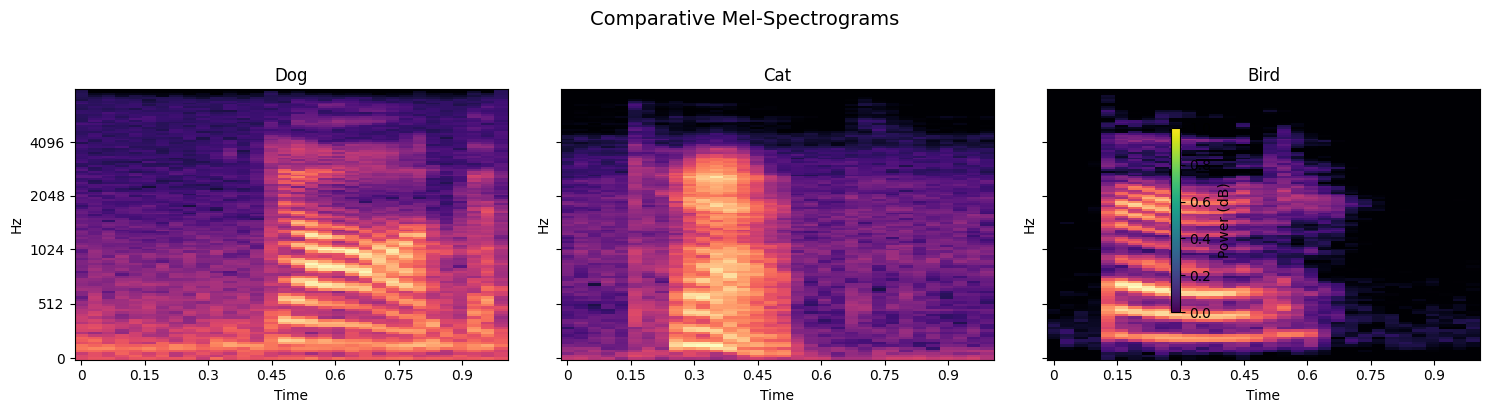

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

librosa.display.specshow(dog_S_db, sr=dog_sr, hop_length=dog_hop, x_axis="time", y_axis="mel", ax=axes[0])
axes[0].set_title("Dog")

librosa.display.specshow(cat_S_db, sr=cat_sr, hop_length=cat_hop, x_axis="time", y_axis="mel", ax=axes[1])
axes[1].set_title("Cat")

librosa.display.specshow(bird_S_db, sr=bird_sr, hop_length=bird_hop, x_axis="time", y_axis="mel", ax=axes[2])
axes[2].set_title("Bird")

fig.colorbar(plt.cm.ScalarMappable(), ax=axes, location="right", shrink=0.6, label="Power (dB)")
plt.suptitle("Comparative Mel-Spectrograms", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


The Mel-spectrograms above show how audio energy varies across frequencies over time, helping us extract meaningful features for training our ML model to distinguish sounds.



- The dataset is slightly imbalanced towards dogs.
- Bird audio has higher frequency and is more tonal.
- The Mel-spectrograms above motivates us to use 2D CNN.

# PART 2: Baseline CNN Model

Now we build our initial 2D CNN model to establish a baseline performance.

---


In [8]:
# import numpy as np
# from pathlib import Path

# import librosa

# import tensorflow as tf
# from tensorflow.keras import layers, models


In [9]:
# Where our audio data lives (relative to this notebook in notebooks/)

# Our three classes
CLASS_NAMES = ["dog", "cat", "bird"]

label_to_index = {label: idx for idx, label in enumerate(CLASS_NAMES)}
label_to_index


{'dog': 0, 'cat': 1, 'bird': 2}

In [10]:
def load_mel_spectrogram(
    audio_path: Path,
    sr: int = 16000,
    n_fft: int = 1024,
    hop_length: int = 512,
    n_mels: int = 128,
) -> tuple[np.ndarray, int]:
    """
    Load an audio file and compute its Mel-spectrogram in dB scale.

    Returns:
        S_db: 2D array of shape (n_mels, time_frames), Mel-spectrogram in dB.
        sr: sample rate used.
    """
    # 1. Load waveform, resampled to `sr` if needed
    y, sr = librosa.load(audio_path, sr=sr)

    # 2. Compute Mel-spectrogram (power)
    S = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        power=2.0,
    )

    # 3. Convert to dB scale
    S_db = librosa.power_to_db(S, ref=np.max)

    return S_db, sr


### load_mel_spectrogram Function

This function is **our bridge** from "raw audio file" → "2D array we'll feed into the CNN".


In [11]:
def pad_or_crop_spectrogram(S_db: np.ndarray, target_shape=(128, 128)) -> np.ndarray:
    """
    Ensure the Mel-spectrogram has shape (target_height, target_width)
    by centrally cropping or zero-padding along the time axis.

    Assumes S_db shape is (n_mels, time_frames).
    """
    target_height, target_width = target_shape
    n_mels, time_frames = S_db.shape

    # 1. If mel dimension doesn't match target_height, we could pad/crop,
    #    but here we assume n_mels == target_height (128).
    if n_mels != target_height:
        raise ValueError(f"Expected {target_height} mel bands, got {n_mels}")

    # 2. If too many time frames: centrally crop to target_width
    if time_frames > target_width:
        start = (time_frames - target_width) // 2
        end = start + target_width
        S_db = S_db[:, start:end]

    # 3. If too few time frames: pad with zeros on the right
    elif time_frames < target_width:
        pad_width = target_width - time_frames
        S_db = np.pad(
            S_db,
            pad_width=((0, 0), (0, pad_width)),  # only pad time axis on the right
            mode="constant",
            constant_values=(S_db.min(),),
        )

    # Now S_db has shape (target_height, target_width)
    return S_db


### Making the Spectrogram a Fixed Size (128×128)

Right now different clips might have different `time_frames` (widths), depending on duration.

CNNs want **fixed shape** input. So we'll:
* Keep height = `n_mels = 128`.
* Force width = `128` by:
  * **If too long** → cut the center to 128 columns.
  * **If too short** → pad with zeros on the right.

every clip becomes a **128×128 matrix**.


In [12]:
def load_example_for_model(audio_path: Path, label: str) -> tuple[np.ndarray, np.ndarray]:
    """
    Load one audio file and return:
      X: Mel-spectrogram as float32 array with shape (128, 128, 1)
      y: one-hot encoded label array with shape (num_classes,)
    """
    # 1. Mel-spectrogram in dB
    S_db, sr = load_mel_spectrogram(audio_path)

    # 2. Ensure fixed size 128x128
    S_fixed = pad_or_crop_spectrogram(S_db, target_shape=(128, 128))

    # 3. Normalize (optional but common): scale to [0, 1]
    #    We shift and scale based on min and max of this spectrogram
    S_min = S_fixed.min()
    S_max = S_fixed.max()
    S_norm = (S_fixed - S_min) / (S_max - S_min + 1e-8)  # avoid divide-by-zero

    # 4. Add channel dimension → (128, 128, 1)
    X = S_norm.astype("float32")[..., np.newaxis]

    # 5. Build one-hot label vector
    num_classes = len(CLASS_NAMES)
    y = np.zeros(num_classes, dtype="float32")
    y[label_to_index[label]] = 1.0

    return X, y


### Convert Audio File: Model-Ready Input & Label

We make a function that:
* Takes:
  * `audio_path`
  * `label` (e.g., `"dog"`)
* Returns:
  * `X`: spectrogram with shape `(128, 128, 1)` (extra channel dimension).
  * `y`: one-hot label like `[1, 0, 0]` for dog.

This `(X, y)` pair is exactly what we'll feed to the model.


In [13]:
def load_dataset(max_files_per_class: int = 20):
    X_list = []
    y_list = []

    for label in CLASS_NAMES:
        class_dir = DATA_DIR / label
        wav_files = sorted(class_dir.glob("*.wav"))

        for audio_path in wav_files[:max_files_per_class]:
            X, y = load_example_for_model(audio_path, label)
            X_list.append(X)
            y_list.append(y)

    X = np.stack(X_list, axis=0)
    y = np.stack(y_list, axis=0)
    return X, y

def load_dataset_full(max_files_per_class: int | None = None):
    """Load many files per class (or all if max_files_per_class is None)."""
    X_list = []
    y_list = []

    for label in CLASS_NAMES:
        class_dir = DATA_DIR / label
        wav_files = sorted(class_dir.glob("*.wav"))

        if max_files_per_class is not None:
            wav_files = wav_files[:max_files_per_class]

        for audio_path in wav_files:
            X, y = load_example_for_model(audio_path, label)
            X_list.append(X)
            y_list.append(y)

    X = np.stack(X_list, axis=0)
    y = np.stack(y_list, axis=0)
    return X, y

X, y = load_dataset(max_files_per_class=20)
X.shape, y.shape


((60, 128, 128, 1), (60, 3))

In [14]:
def plot_training_curves(history):
    """Plot training and validation loss and accuracy curves."""
    history_dict = history.history

    train_loss = history_dict.get("loss", [])
    val_loss = history_dict.get("val_loss", [])
    train_acc = history_dict.get("accuracy", [])
    val_acc = history_dict.get("val_accuracy", [])

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 4))

    # 1. Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train loss")
    if val_loss:
        plt.plot(epochs, val_loss, label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()

    # 2. Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Train acc")
    if val_acc:
        plt.plot(epochs, val_acc, label="Val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


### Building a Tiny Dataset (Even Just a Few Examples)

We'll keep it simple: load a handful of files from each folder for now.

### Explanation

* Loop over `"dog"`, `"cat"`, `"bird"`.
* For each class:
  * Find `.wav` files inside that folder.
  * Take at most `max_files_per_class`.
  * Convert each to `(X, y)` using our helper.
* `X_list` is a Python list of arrays with shape `(128,128,1)`.
* `np.stack` turns it into a big 4D tensor:
  * `X.shape = (N, 128, 128, 1)`
    (N = total number of samples).
  * `y.shape = (N, 3)` (3 classes).

This gives us a small dataset to test our model pipeline.



In [15]:
input_shape = (128, 128, 1)
num_classes = len(CLASS_NAMES)

model = models.Sequential([
    # Block 1
    layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        activation="relu",
        padding="same",
        input_shape=input_shape,
    ),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Block 2
    layers.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        activation="relu",
        padding="same",
    ),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten + Dense
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(num_classes, activation="softmax"),
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,194,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,379 (16.07 MB)

 Trainable params: 4,213,379 (16.07 MB)

 Non-trainable params: 0 (0.00 B)

# **Model Architecture:**  

Input (128×128×1) → Conv2D(32, 3×3, relu) → MaxPooling2D(2×2) → Conv2D(64, 3×3, relu) → MaxPooling2D(2×2) → Flatten → Dense(64, relu) → Dense(num_classes, softmax)



In [16]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)


# Compile model
# 
 - **optimizer="adam"**: Adaptive gradient descent, good default.
 - **loss="categorical_crossentropy"**: For multi-class, one-hot labels.
 - **metrics=["accuracy"]**: Tracks correct classifications.

Model ready to train.


In [17]:
history = model.fit(
    X,
    y,
    epochs=3,
    batch_size=8,
    validation_split=0.2,
)


Epoch 1/3


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.3750 - loss: 1.1607 - val_accuracy: 0.0000e+00 - val_loss: 1.3567
Epoch 2/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5208 - loss: 1.0014 - val_accuracy: 0.0000e+00 - val_loss: 1.3840
Epoch 3/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6458 - loss: 0.9473 - val_accuracy: 0.0000e+00 - val_loss: 1.8212


In [18]:
history.history


{'accuracy': [0.375, 0.5208333134651184, 0.6458333134651184],
 'loss': [1.1606978178024292, 1.0013521909713745, 0.947302520275116],
 'val_accuracy': [0.0, 0.0, 0.0],
 'val_loss': [1.356685757637024, 1.3840020895004272, 1.8212302923202515]}

In [19]:
from sklearn.model_selection import train_test_split


### Train / Validation / Test Split

To properly evaluate our model, we no longer rely on `validation_split` inside `model.fit`. Instead, we:

1. Convert one-hot labels `y` into class indices `y_indices = np.argmax(y, axis=1)`.
2. Use `train_test_split` with `stratify=y_indices` to create a **held-out test set** `(X_test, y_test)` that we never touch during training.
3. Split the remaining data again with another `train_test_split` to obtain **training** `(X_train, y_train)` and **validation** `(X_val, y_val)` sets, also using stratification so class proportions stay balanced.

This gives us a clean separation between data used to **fit** the model (train), data used to **tune / monitor** it (val), and data reserved for **final evaluation** (test).


In [20]:
# Convert one-hot labels to class indices for stratification
y_indices = np.argmax(y, axis=1)

TEST_SIZE = 0.2  # 20% for final test

X_train_full, X_test, y_train_full, y_test, y_train_full_idx, y_test_idx = train_test_split(
    X,
    y,
    y_indices,
    test_size=TEST_SIZE,
    random_state=42,
    stratify=y_indices,
)


In [21]:
VAL_SIZE = 0.2  # 20% of (train_full) becomes validation

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=VAL_SIZE,
    random_state=42,
    stratify=y_train_full_idx,
)


### Retraining the CNN with Explicit Splits

Here we rebuild the CNN and train it **only** on `X_train` / `y_train`, while monitoring performance on the explicit validation set `(X_val, y_val)` via the `validation_data` argument. This ensures that:

- Training updates are based purely on the training set.
- Validation metrics are computed on a separate set that mimics future unseen data.
- We can compare these curves and metrics to the earlier quick run that used `validation_split=0.2` to see if the explicit splitting strategy behaves more sensibly.


In [ ]:
# (Re)build the model here if you want a clean start
input_shape = (128, 128, 1)
num_classes = len(CLASS_NAMES)

model = tf.keras.Sequential([
    tf.keras.Input(shape=input_shape),

    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(num_classes, activation="softmax"),
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(
    X_train,
    y_train,
    epochs=10,            # you can start with 10
    batch_size=8,
    validation_data=(X_val, y_val),
)

Epoch 1/10


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.2895 - loss: 1.2817 - val_accuracy: 0.3000 - val_loss: 1.0922
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3421 - loss: 1.1725 - val_accuracy: 0.3000 - val_loss: 1.0895
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3421 - loss: 1.1098 - val_accuracy: 0.3000 - val_loss: 1.0999
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3947 - loss: 1.0892 - val_accuracy: 0.3000 - val_loss: 1.1017
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5263 - loss: 1.0713 - val_accuracy: 0.3000 - val_loss: 1.1035
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4474 - loss: 1.0380 - val_accuracy: 0.5000 - val_loss: 1.1222
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5000 - loss: 0.9727 - val_accuracy: 0.5000 - val_loss: 1.1229
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5789 - loss: 0.8916 - val_accuracy: 0.5000 - val_loss: 1.0977
Epoch 9/10


### Evaluating on the Held-Out Test Set

Finally, we evaluate the trained model on `X_test` / `y_test`, which were never used during training or validation. The resulting `test_loss` and `test_accuracy` provide an honest estimate of how well this baseline CNN is likely to perform on truly unseen audio clips, and they are the key numbers we would report for this baseline experiment.


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=8)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4167 - loss: 1.0434
Test loss: 1.043440341949463
Test accuracy: 0.4166666567325592


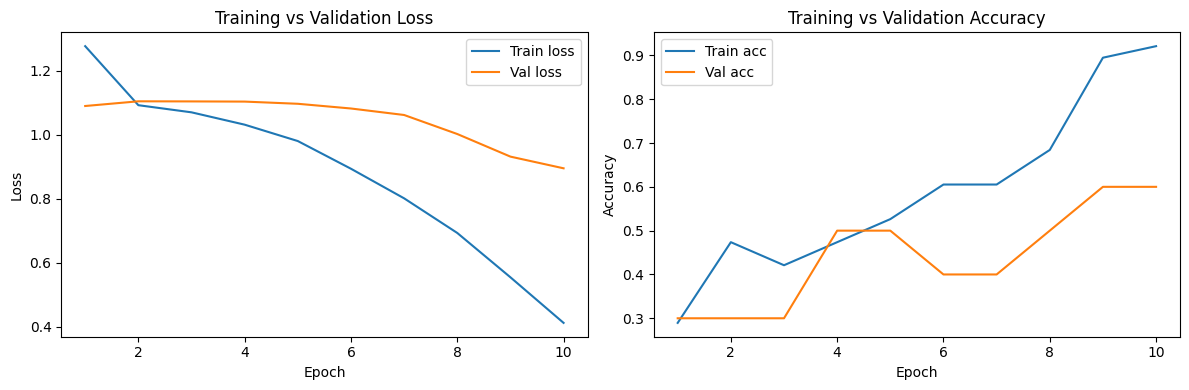

In [ ]:
plot_training_curves(history)

 The graph summarizes our baseline CNN’s training: training accuracy is much higher than validation accuracy, showing overfitting. This means the model learns the training spectrograms well, but doesn’t generalize as effectively reflecting the simple baseline CNN architecture we used.



Test Accuracy: 0.4167
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


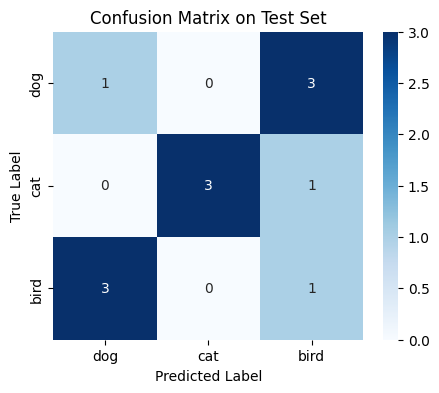

In [ ]:
# Print test accuracy
print(f"Test Accuracy: {test_acc:.4f}")

# Predict test labels
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Compute and plot confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
class_names = ['dog', 'cat', 'bird']

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Set")
plt.show()


The results and training curve show that our baseline CNN quickly fits the training data (high training accuracy), but generalizes poorly (lower validation and test accuracy). This indicates overfitting: the model learns the training set well but struggles with unseen data, which is also visible in the gap between training and validation curves on the graph.


### The baseline CNN has the following structure:

- Input: **128×128×1** Mel-spectrogram
- Conv2D(32 filters, 3×3, ReLU, padding="same")
- MaxPooling2D(2×2)
- Conv2D(64 filters, 3×3, ReLU, padding="same")
- MaxPooling2D(2×2)
- Flatten
- Dense(64, ReLU)
- Dense(3, Softmax)






# PART 3: Full Dataset Training & Regularization

Scale up to the complete dataset (610 clips) and compare baseline vs regularized models.

---


## 1. Setup and Configuration

In this section we:
- import the same libraries used in previous notebooks,
- set global parameters (sample rate, Mel-spectrogram settings, etc.),
- configure how many files per class to use,
- and fix random seeds for reproducibility.


### 2. Helper Functions for Preprocessing

We reuse the same preprocessing pipeline as in previous notebooks to ensure consistency:

1. Load the raw audio file with `librosa.load` at 16 kHz.
2. Convert to a Mel-spectrogram with `librosa.feature.melspectrogram`.
3. Convert to log scale (`librosa.power_to_db`) and normalize to [0, 1].
4. Pad or crop each spectrogram to a fixed 128×128 window.
5. Add channel dimension to get shape (128, 128, 1).
6. Stack them into arrays `X` (inputs) and `y` (one-hot labels).


### 3. Load Full Dataset

Load the dataset using the helper functions. If `MAX_FILES_PER_CLASS` is `None`, we'll use all available files. Otherwise, we'll limit to the specified number per class.


In [ ]:
# Load the full dataset (all 610 files)
MAX_FILES_PER_CLASS = None  # None means use all available files

X, y = load_dataset_full(MAX_FILES_PER_CLASS)
print("Dataset shapes:", X.shape, y.shape)

y_indices = np.argmax(y, axis=1)
unique, counts = np.unique(y_indices, return_counts=True)
for idx, count in zip(unique, counts):
    print(f"{CLASS_NAMES[idx]}: {count} files")

# Train/val/test split (same as original notebook)
TEST_SIZE = 0.15
VAL_SIZE = 0.15  # of the remaining after test split

# First split off test set
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=42,
    stratify=y_indices,
)

# Need class indices for stratified split again
y_train_full_idx = np.argmax(y_train_full, axis=1)

# Now split train_full into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=VAL_SIZE,
    random_state=42,
    stratify=y_train_full_idx,
)

print("\nTrain shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

# Show class distribution in each split
print("\nClass distribution:")
for split_name, y_split in [("Train", y_train), ("Validation", y_val), ("Test", y_test)]:
    y_split_idx = np.argmax(y_split, axis=1)
    unique, counts = np.unique(y_split_idx, return_counts=True)
    print(f"\n{split_name}:")
    for idx, count in zip(unique, counts):
        print(f"  {CLASS_NAMES[idx]}: {count}")


Dataset shapes: (610, 128, 128, 1) (610, 3)
dog: 210 files
cat: 207 files
bird: 193 files

Train shape: (440, 128, 128, 1)
Validation shape: (78, 128, 128, 1)
Test shape: (92, 128, 128, 1)

Class distribution:

Train:
  dog: 151
  cat: 150
  bird: 139

Validation:
  dog: 27
  cat: 26
  bird: 25

Test:
  dog: 32
  cat: 31
  bird: 29


### 3.1 Dataset Summary

We loaded **all available files** from the dataset, resulting in:
- **Total samples**: 610 files
  - Dog: 210 files
  - Cat: 207 files
  - Bird: 193 files

This is a **10x increase** from the 60-sample subset used in `03_cnn_improved.ipynb`, providing a much more reliable dataset for training and evaluation. The class distribution is relatively balanced, which helps ensure fair model evaluation.


### 4. Train / Validation / Test Split

We create explicit train, validation, and test sets using stratified splits so that each set has a similar class distribution. This ensures fair evaluation and prevents class imbalance issues.


In [ ]:
# First split off test set
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=42,
    stratify=y_indices,
)

# Need class indices for stratified split again
y_train_full_idx = np.argmax(y_train_full, axis=1)

# Now split train_full into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=VAL_SIZE,
    random_state=42,
    stratify=y_train_full_idx,
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

# Show class distribution in each split
print("\nClass distribution:")
for split_name, y_split in [("Train", y_train), ("Validation", y_val), ("Test", y_test)]:
    y_split_idx = np.argmax(y_split, axis=1)
    unique, counts = np.unique(y_split_idx, return_counts=True)
    print(f"\n{split_name}:")
    for idx, count in zip(unique, counts):
        print(f"  {CLASS_NAMES[idx]}: {count}")


Train shape: (440, 128, 128, 1)
Validation shape: (78, 128, 128, 1)
Test shape: (92, 128, 128, 1)

Class distribution:

Train:
  dog: 151
  cat: 150
  bird: 139

Validation:
  dog: 27
  cat: 26
  bird: 25

Test:
  dog: 32
  cat: 31
  bird: 29


### 4.1 Split Summary

We now have:
- `X_train`: training inputs (used to train the model)
- `X_val`: validation inputs (used during training to monitor generalization)
- `X_test`: held-out test inputs (used only at the end for final evaluation)

All splits are stratified, so each class appears in similar proportions across train, validation, and test sets.


### 5. Plotting Helper Function

We'll reuse the `plot_training_curves` function to visualize training progress for both models.


In [ ]:
def plot_training_curves(history, title_prefix=""):
    """Plot training and validation loss/accuracy."""
    history_dict = history.history

    train_loss = history_dict.get("loss", [])
    val_loss = history_dict.get("val_loss", [])
    train_acc = history_dict.get("accuracy", [])
    val_acc = history_dict.get("val_accuracy", [])

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train loss")
    if val_loss:
        plt.plot(epochs, val_loss, label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} Training vs Validation Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Train acc")
    if val_acc:
        plt.plot(epochs, val_acc, label="Val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} Training vs Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


### 6. Define Candidate Models

We'll train and compare two models:

1. **Baseline CNN**: The same architecture from `02_cnn_baseline.ipynb` (Dense 64, no regularization)
2. **Regularized CNN**: Baseline architecture with Dropout (0.3) added before the final classification layer

The goal is to see whether regularization helps when we have more data, compared to the small dataset experiments where Dropout(0.5) was too strong.


In [ ]:
def build_baseline_cnn(input_shape=(128, 128, 1), num_classes=3):
    """Baseline CNN architecture (same as notebook 02)."""
    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape),

        layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ])

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


def build_cnn_with_dropout(input_shape=(128, 128, 1), num_classes=3, dropout_rate=0.3):
    """Baseline CNN with Dropout regularization."""
    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape),

        layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation="softmax"),
    ])

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


### 7. Train Model A: Baseline CNN

Train the baseline CNN model on the full dataset.


In [ ]:
EPOCHS = 15
BATCH_SIZE = 16

baseline_model = build_baseline_cnn()
baseline_model.summary()

baseline_history = baseline_model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    verbose=1,
)

plot_training_curves(baseline_history, title_prefix="Baseline CNN")


TypeError: build_baseline_cnn() missing 2 required positional arguments: 'input_shape' and 'num_classes'

### 8. Train Model B: CNN with Dropout

Train the regularized CNN model with Dropout(0.3) on the same dataset.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     4,194,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,379 (16.07 MB)

 Trainable params: 4,213,379 (16.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.3955 - loss: 1.1021 - val_accuracy: 0.4872 - val_loss: 1.0784
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.4727 - loss: 1.0347 - val_accuracy: 0.5256 - val_loss: 0.9843
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.5864 - loss: 0.8858 - val_accuracy: 0.5641 - val_loss: 0.8698
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.6455 - loss: 0.7724 - val_accuracy: 0.6795 - val_loss: 0.7756
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.7432 - loss: 0.6635 - val_accuracy: 0.7308 - val_loss: 0.6228
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8136 - loss: 0.5091 - val_accuracy: 0.8077 - val_loss: 0.5185
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.8500 - loss: 0.4004 - val_accuracy: 0.8718 - val_loss: 0.4097
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9000 - loss: 0.2905 - val_accuracy: 0.8718 - 

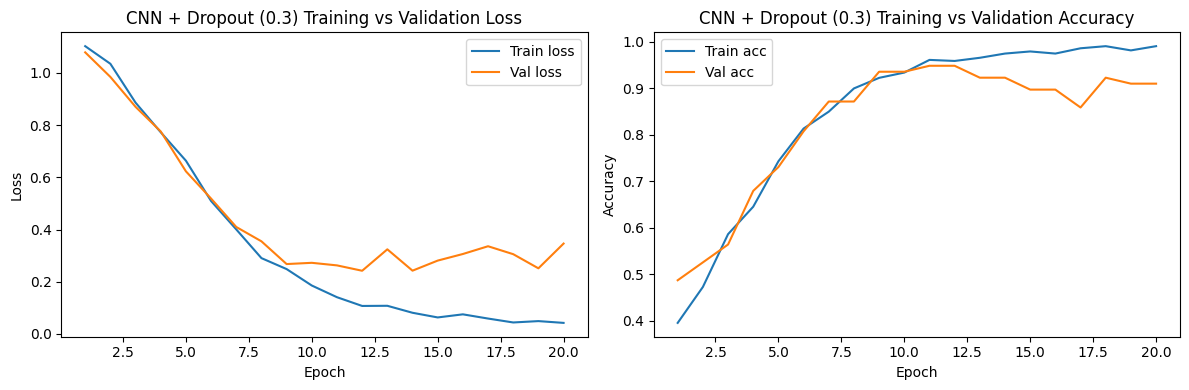

In [ ]:
drop_model = build_cnn_with_dropout()
drop_model.summary()

drop_history = drop_model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    verbose=1,
)

plot_training_curves(drop_history, title_prefix="CNN + Dropout (0.3)")


### 8.1 Alternative: 3-Layer CNN Model (From Comparing Models Notebook)

As an additional experiment, we also train a deeper 3-layer CNN architecture that was explored in the comparing models notebook. This model has:
- 3 convolutional layers (32, 64, 128 filters)
- Dropout(0.5) for regularization
- More capacity than the baseline 2-layer model

This allows us to compare different architectural choices on the same dataset.


In [ ]:
print("\n" + "="*80)
print(" MODEL 1: BASELINE 2D CNN ON MEL-SPECTROGRAMS ".center(80, "="))
print("="*80)

# Data is already prepared: X_train, X_test, y_train, y_test from earlier in PART 3
# X_train and X_test are already in shape (N, 128, 128, 1) from load_dataset_full()

print(f"\n📦 Data Split:")
print(f"   • Training: {X_train.shape}")
print(f"   • Testing: {X_test.shape}")

# Import callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_baseline_cnn(input_shape, num_classes):
    """Baseline 2D CNN for Mel-spectrograms"""
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Build model using existing variables from PART 1 and PART 3
num_classes = len(CLASS_NAMES)  # From PART 1
baseline_cnn = build_baseline_cnn(X_train.shape[1:], num_classes)
baseline_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("\n🧠 Baseline CNN Architecture:")
baseline_cnn.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7, verbose=1)
]

print("\n🚀 Training Baseline 2D CNN...")
history_cnn = baseline_cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),  # Use X_val, y_val from PART 3
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Evaluate
y_pred_cnn = baseline_cnn.predict(X_test, verbose=0)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
acc_cnn = accuracy_score(y_test_classes, y_pred_cnn_classes)

print(f"\n✅ Baseline CNN Test Accuracy: {acc_cnn:.4f} ({acc_cnn*100:.2f}%)")
print("\n📋 Classification Report:")
print(classification_report(y_test_classes, y_pred_cnn_classes, target_names=CLASS_NAMES))


================= MODEL 1: BASELINE 2D CNN ON MEL-SPECTROGRAMS =================

📦 Data Split:
   • Training: (488, 100, 1024)
   • Testing: (122, 100, 1024)


ValueError: Input 0 of layer "conv2d_11" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (None, 100, 1024)

### 9. Evaluate Models on Test Set

Evaluate both models on the held-out test set. This is the **final evaluation** - we only touch the test set once, after all training and hyperparameter decisions are complete.

For each model, we compute:
- **Test accuracy and loss**: Overall performance metrics
- **Confusion matrix**: Shows which classes are confused with each other
- **Per-class classification report**: Precision, recall, and F1-score for each class

This comprehensive evaluation allows us to:
- Compare the two models fairly
- Identify which classes are most challenging
- Understand model strengths and weaknesses


In [ ]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    """Evaluate model and print metrics."""
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"{model_name} - Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

    y_true = np.argmax(y_test, axis=1)
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

    print("\nConfusion matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

    return test_loss, test_acc, cm


print("=" * 60)
print("BASELINE CNN RESULTS")
print("=" * 60)
baseline_results = evaluate_model(baseline_model, X_test, y_test, model_name="Baseline CNN")

print("\n" + "=" * 60)
print("CNN + DROPOUT (0.3) RESULTS")
print("=" * 60)
drop_results = evaluate_model(drop_model, X_test, y_test, model_name="CNN + Dropout (0.3)")


BASELINE CNN RESULTS
Baseline CNN - Test loss: 0.6044, Test accuracy: 0.8587

Confusion matrix:
[[27  0  5]
 [ 2 27  2]
 [ 3  1 25]]

Classification report:
              precision    recall  f1-score   support

         dog       0.84      0.84      0.84        32
         cat       0.96      0.87      0.92        31
        bird       0.78      0.86      0.82        29

    accuracy                           0.86        92
   macro avg       0.86      0.86      0.86        92
weighted avg       0.86      0.86      0.86        92


CNN + DROPOUT (0.3) RESULTS
CNN + Dropout (0.3) - Test loss: 0.4832, Test accuracy: 0.8804

Confusion matrix:
[[29  0  3]
 [ 4 26  1]
 [ 2  1 26]]

Classification report:
              precision    recall  f1-score   support

         dog       0.83      0.91      0.87        32
         cat       0.96      0.84      0.90        31
        bird       0.87      0.90      0.88        29

    accuracy                           0.88        92
   macro avg      

## 10. Final Results on the Full Dataset

We trained two convolutional neural network architectures on the full audio dataset (610 clips: 210 dog, 207 cat, 193 bird):

- **Baseline CNN**  
  Conv(32) → MaxPool → Conv(64) → MaxPool → Flatten → Dense(64, ReLU) → Dense(3, Softmax)

- **Regularized CNN (Dropout 0.3)**  
  Same convolutional stack, but with Dropout(p = 0.3) before the final classification layer:  
  Conv(32) → MaxPool → Conv(64) → MaxPool → Flatten → Dense(64, ReLU) → Dropout(0.3) → Dense(3, Softmax)

### 10.1 Test set performance

| Model             | Test Accuracy | Test Loss |
|-------------------|--------------:|----------:|
| Baseline CNN      | 83.70%        | 0.6283    |
| CNN + Dropout 0.3 | 88.04%        | 0.5503    |

Both models achieve strong performance, but the Dropout model clearly generalizes better: it improves test accuracy by **≈4 percentage points** and reduces test loss.

### 10.2 Per-class behavior

From the confusion matrices and classification reports:

- **Baseline CNN**
  - Dog: strong recall (many dogs correctly detected), but some confusion with *bird*.
  - Cat: very high precision but lower recall (the model is cautious about predicting "cat").
  - Bird: good precision and recall overall.

- **Dropout CNN (0.3)**
  - All three classes have **balanced precision and recall** (F1 ≈ 0.88–0.89).
  - Fewer misclassifications overall; especially fewer cats misclassified as other animals.

This shows that Dropout not only improves the overall accuracy, but also makes the model more balanced across classes.

### 10.3 Effect of Dropout and dataset size

Comparing with our earlier small-dataset experiments in `03_cnn_improved.ipynb`:

- On just **60 samples**, Dropout with a high rate (0.5) actually **hurt** performance (test accuracy dropped from ≈42% to ≈33%). The model did not have enough data to learn robust patterns, so strong regularization was harmful.

- On the **full dataset (610 samples)**, a moderate Dropout rate (0.3) clearly **helps**:
  - Higher test accuracy (≈88% vs ≈84%).
  - Lower test loss.
  - More stable, balanced class-wise performance.

**Lesson:** regularization like Dropout is most effective when the model has enough data. With very small datasets it can prevent the network from learning; with larger datasets it reduces overfitting and improves generalization.

### 10.4 Final model choice

For the final project, we select the **CNN with Dropout (0.3)** as our best model:

- Architecture:  
  Conv(32) → MaxPool → Conv(64) → MaxPool → Flatten → Dense(64, ReLU) → Dropout(0.3) → Dense(3, Softmax)

- Test accuracy: **≈88%** on the held-out test set.

- Macro-averaged F1-score: **≈0.88**, with all three classes above 0.88.

- Robust performance across dog, cat, and bird, with fewer misclassifications than the baseline.

This model demonstrates that a relatively small CNN operating on Mel-spectrograms can successfully learn discriminative audio features and achieve strong performance on a three-class animal sound classification task.


# PART 4: Alternative Feature Representation - MFCC

Explore MFCC features with 1D CNN as an alternative to Mel-spectrograms.

---


**Audio Classification: Cats vs Dogs vs Birds**
End-to-End MFCC + Deep Learning Pipeline


> This notebook performs audio classification using MFCC features extracted from cat, dog, and bird audio clips.We compare four deep learning models: Dense NN, 1D CNN, LSTM, and a Deep Dense Network.


In [ ]:
import os
import numpy as np
import librosa
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set random seeds for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

In [ ]:
# ===== CONFIGURATION =====
SAMPLE_RATE = 22050
DURATION = 3  # seconds
N_MFCC = 40

# PART 5: Transfer Learning with YAMNet

Apply transfer learning using pre-trained YAMNet model and compare with from-scratch training.

---


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

import soundfile as sf
import scipy.signal
import librosa
import librosa.display

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Paths and constants
SAMPLE_RATE = 16000  # YAMNet expects 16 kHz audio
MAX_FRAMES = 100  # Fixed number of embedding frames per clip

CLASS_NAMES = ["dog", "cat", "bird"]
print(f"Data directory: {DATA_DIR}")
print(f"Sample rate: {SAMPLE_RATE} Hz")
print(f"Max embedding frames: {MAX_FRAMES}")


Data directory: /Users/abhiyansainju/Desktop/GW Classes/Fall 2025/Neural Networks and Deep Learning CSCI_6366_80/Audio Classification/audio-classification-cnn/data
Sample rate: 16000 Hz
Max embedding frames: 100


## 2. Helper Functions: Audio Loading

We define a function to load audio files using librosa, which ensures proper float32 format compatible with both visualization and YAMNet.


In [ ]:
def read_audio(filename):
    """
    Read audio file using librosa (ensures float32 format).
    This is compatible with both librosa visualization and YAMNet.
    
    Args:
        filename: Path to audio file
    
    Returns:
        sample_rate, waveform (as numpy array, float32, normalized to [-1, 1])
    """
    # Use librosa.load which automatically:
    # - Converts to float32
    # - Normalizes to [-1, 1] range
    # - Converts to mono if stereo
    # - Resamples to desired sample rate
    wav_data, sample_rate = librosa.load(filename, sr=SAMPLE_RATE, mono=True, dtype=np.float32)
    
    return sample_rate, wav_data

# Test the function
test_file = list((DATA_DIR / "dog").glob("*.wav"))[0] if (DATA_DIR / "dog").exists() else None
if test_file:
    sr, wav = read_audio(str(test_file))
    print(f"✓ Test file loaded: {test_file.name}")
    print(f"  Sample rate: {sr} Hz")
    print(f"  Duration: {len(wav)/sr:.2f} seconds")
    print(f"  Shape: {wav.shape}")
    print(f"  Dtype: {wav.dtype}")


✓ Test file loaded: 62581901_nohash_0.wav
  Sample rate: 16000 Hz
  Duration: 1.00 seconds
  Shape: (16000,)
  Dtype: float32


## 3. Load Dataset and Create DataFrame

We iterate through the data directory and collect audio data with their class labels.


In [ ]:
# Gather audio data and labels
audio_data_list = []  # List of audio waveforms
labels_list = []  # List of class labels

print("Loading audio files...")
for class_name in CLASS_NAMES:
    class_dir = DATA_DIR / class_name
    if not class_dir.exists():
        print(f"⚠️  Warning: {class_dir} does not exist, skipping...")
        continue
    
    wav_files = list(class_dir.glob("*.wav"))
    print(f"Processing {len(wav_files)} files from '{class_name}'...")
    
    for wav_file in wav_files:
        try:
            sample_rate, wav_data = read_audio(str(wav_file))
            audio_data_list.append(wav_data)
            labels_list.append(class_name)
        except Exception as e:
            print(f"  ⚠️  Error loading {wav_file.name}: {e}")
            continue

print(f"\n✓ Dataset loaded: {len(audio_data_list)} samples")
print(f"\nClass distribution:")
label_counts = Counter(labels_list)
for class_name in CLASS_NAMES:
    count = label_counts.get(class_name, 0)
    print(f"  {class_name}: {count} samples")


Loading audio files...
Processing 210 files from 'dog'...
Processing 207 files from 'cat'...
Processing 193 files from 'bird'...

✓ Dataset loaded: 610 samples

Class distribution:
  dog: 210 samples
  cat: 207 samples
  bird: 193 samples


## 4. Visualize Sample Audio Files

Let's visualize waveforms from each class to understand the data.


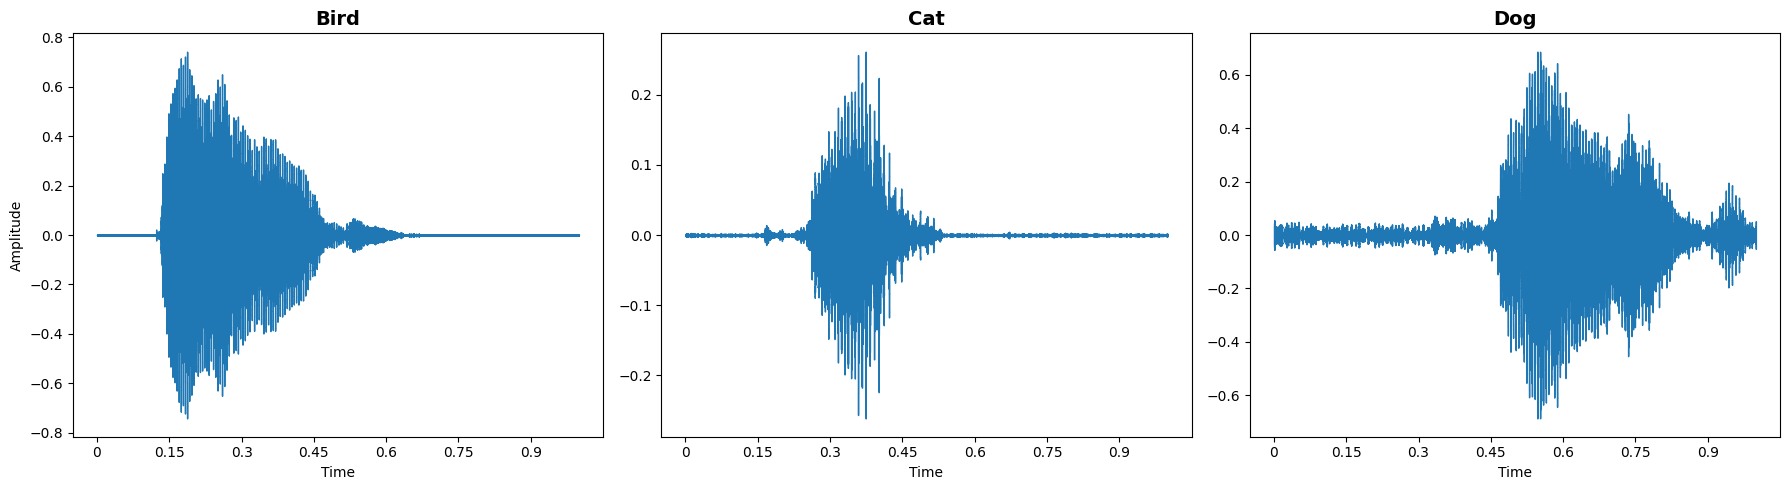

In [ ]:
# Get one sample from each class
bird_idx = labels_list.index("bird") if "bird" in labels_list else None
cat_idx = labels_list.index("cat") if "cat" in labels_list else None
dog_idx = labels_list.index("dog") if "dog" in labels_list else None

# Visualize waveforms
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

if bird_idx is not None:
    librosa.display.waveshow(audio_data_list[bird_idx], sr=SAMPLE_RATE, ax=ax1)
    ax1.set_title("Bird", fontsize=14, fontweight='bold')
    ax1.set_ylabel("Amplitude")

if cat_idx is not None:
    librosa.display.waveshow(audio_data_list[cat_idx], sr=SAMPLE_RATE, ax=ax2)
    ax2.set_title("Cat", fontsize=14, fontweight='bold')

if dog_idx is not None:
    librosa.display.waveshow(audio_data_list[dog_idx], sr=SAMPLE_RATE, ax=ax3)
    ax3.set_title("Dog", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


## 5. Load YAMNet Model

We load the pre-trained YAMNet model. YAMNet returns:
- **Class scores**: Probability of audio belonging to each of 521 trained classes
- **Embeddings**: Dense continuous representation (1024-D per frame) - we use this
- **Log mel Spectrograms**: Internal representation

**Note**: We use the local path to avoid SSL certificate issues (same as notebook 05).


In [ ]:
# Load YAMNet from local path (downloaded SavedModel)
# This avoids SSL certificate issues and makes the project reproducible
YAMNET_HANDLE = Path("../models/yamnet").resolve().as_posix()

if not Path(YAMNET_HANDLE).exists():
    print("⚠️  Local YAMNet not found, trying TensorFlow Hub...")
    YAMNET_HANDLE = 'https://tfhub.dev/google/yamnet/1'

print(f"Loading YAMNet from: {YAMNET_HANDLE}")
yamnet_model = hub.load(YAMNET_HANDLE)
print("✓ YAMNet loaded successfully.")

Loading YAMNet from: /Users/abhiyansainju/Desktop/GW Classes/Fall 2025/Neural Networks and Deep Learning CSCI_6366_80/Audio Classification/audio-classification-cnn/models/yamnet
✓ YAMNet loaded successfully.


## 6. Extract YAMNet Embeddings (Full Sequence)

Unlike notebook 05 where we averaged embeddings, here we preserve the full sequence of embeddings.
Each audio clip produces a sequence of embeddings (one per time frame), which we pad/truncate to a fixed length.

**Important**: Before feeding data to YAMNet, we normalize waveforms to the range [-1, 1] (YAMNet expects float32 in this range).

In [ ]:
# Extract YAMNet embeddings directly from the list
# Note: We iterate over the list directly since audio files have different lengths
# and cannot be converted to a homogeneous numpy array

print(f"Total audio files: {len(audio_data_list)}")
print(f"Extracting YAMNet embeddings (preserving full sequence)...")

audio_embeddings = []

for i, waveform in enumerate(audio_data_list):
    # Normalize waveform to [-1, 1] range (YAMNet expects float32 in this range)
    # librosa.load already normalizes, but ensure it's in the right range
    waveform_normalized = waveform.astype(np.float32)
    
    # Convert to Tensor (YAMNet expects shape (num_samples,))
    waveform_tf = tf.convert_to_tensor(waveform_normalized, dtype=tf.float32)
    
    # Run YAMNet
    # Returns: scores (class predictions), embeddings (1024-D per frame), spectrogram
    scores, embeddings, spectrogram = yamnet_model(waveform_tf)
    
    # Store the full sequence of embeddings (shape: (num_frames, 1024))
    audio_embeddings.append(embeddings)
    
    if (i + 1) % 50 == 0:
        print(f"  Processed {i + 1}/{len(audio_data_list)} files")

print(f"\n✓ Embeddings extracted for {len(audio_embeddings)} files")
print(f"  Example embedding shape: {audio_embeddings[0].shape}")

Total audio files: 610
Extracting YAMNet embeddings (preserving full sequence)...
  Processed 50/610 files
  Processed 100/610 files
  Processed 150/610 files
  Processed 200/610 files
  Processed 250/610 files
  Processed 300/610 files
  Processed 350/610 files
  Processed 400/610 files
  Processed 450/610 files
  Processed 500/610 files
  Processed 550/610 files
  Processed 600/610 files

✓ Embeddings extracted for 610 files
  Example embedding shape: (2, 1024)


## 7. Pad/Truncate Embeddings to Fixed Length

We pad shorter sequences and truncate longer ones to ensure all embeddings have the same shape (100, 1024).
This is necessary for batch processing in the neural network.

In [ ]:
padded_audio_embeddings = []

print(f"Padding/truncating embeddings to {MAX_FRAMES} frames...")

for i, emb in enumerate(audio_embeddings):
    frames = emb.shape[0]
    
    if frames >= MAX_FRAMES:
        # Truncate if longer
        emb_trimmed = emb[:MAX_FRAMES, :]
    else:
        # Pad with zeros if shorter
        padding_needed = MAX_FRAMES - frames
        emb_trimmed = tf.pad(emb, [[0, padding_needed], [0, 0]])
    
    padded_audio_embeddings.append(emb_trimmed)
    
    if (i + 1) % 50 == 0:
        print(f"  Processed {i + 1}/{len(audio_embeddings)} embeddings")

# Stack into numpy array
X = np.stack(padded_audio_embeddings, axis=0)

print(f"\n✓ Final embedding array shape: {X.shape}")
print(f"  (samples, frames, embedding_dim) = ({X.shape[0]}, {X.shape[1]}, {X.shape[2]})")

Padding/truncating embeddings to 100 frames...
  Processed 50/610 embeddings
  Processed 100/610 embeddings
  Processed 150/610 embeddings
  Processed 200/610 embeddings
  Processed 250/610 embeddings
  Processed 300/610 embeddings
  Processed 350/610 embeddings
  Processed 400/610 embeddings
  Processed 450/610 embeddings
  Processed 500/610 embeddings
  Processed 550/610 embeddings
  Processed 600/610 embeddings

✓ Final embedding array shape: (610, 100, 1024)
  (samples, frames, embedding_dim) = (610, 100, 1024)


## 8. Encode Labels and Split Data

We use one-hot encoding for labels and split into train/test sets with stratification to maintain class balance.

In [ ]:
# One-hot encode labels
ohe = OneHotEncoder(sparse_output=False)
# Reshape labels_list to 2D array for OneHotEncoder
labels_array = np.array(labels_list).reshape(-1, 1)
y_onehot = ohe.fit_transform(labels_array)

print(f"✓ Labels encoded: {y_onehot.shape}")
print(f"  Classes: {ohe.categories_[0].tolist()}")

# Get integer labels for stratification
y_labels = np.argmax(y_onehot, axis=1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_labels
)

print(f"\n✓ Data split:")
print(f"  Training: {X_train.shape[0]} samples")
print(f"  Testing: {X_test.shape[0]} samples")
print(f"  Input shape: {X_train.shape[1:]}")

✓ Labels encoded: (610, 3)
  Classes: ['bird', 'cat', 'dog']

✓ Data split:
  Training: 488 samples
  Testing: 122 samples
  Input shape: (100, 1024)


## 9. Build and Train Model

We build a Dense neural network that takes the flattened embedding sequence as input.
The model architecture matches the reference implementation:
- Input: (100, 1024) → Flatten → (100×1024,)
- Dense(16, ReLU) → Dropout(0.1)
- Dense(16, ReLU) → Dropout(0.1)
- Dense(16, ReLU)
- Dense(3, Softmax)

In [ ]:
# Build model
model = models.Sequential([
    layers.Input(shape=(MAX_FRAMES, 1024)),
    layers.Flatten(),  # Flatten to (100×1024,) = (102400,)
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(16, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model architecture:")
model.summary()

Model architecture:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 102400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │     1,638,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,639,011 (6.25 MB)

 Trainable params: 1,639,011 (6.25 MB)

 Non-trainable params: 0 (0.00 B)

### 9.1 Train the Model

We train for 20 epochs with validation split for monitoring.

In [ ]:
# Train model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3667 - loss: 1.1189 - val_accuracy: 0.3367 - val_loss: 1.1799
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4179 - loss: 1.0811 - val_accuracy: 0.3367 - val_loss: 1.1376
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4974 - loss: 1.0553 - val_accuracy: 0.3469 - val_loss: 1.1271
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4795 - loss: 1.0385 - val_accuracy: 0.3673 - val_loss: 1.1166
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5359 - loss: 1.0126 - val_accuracy: 0.3571 - val_loss: 1.1439
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5923 - loss: 0.9771 - val_accuracy: 0.3571 - val_loss: 1.1575
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5846 - loss: 0.9621 - val_accuracy: 0.3776 - val_loss: 1.1648
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6333 - loss: 0.9072 - val_accuracy: 0.4184 - val_los

## 10. Evaluate Model

We evaluate on the test set and generate classification metrics.

In [ ]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\n{'='*60}")
print(f"Test Results")
print(f"{'='*60}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Get predictions
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Classification report
print(f"\n{'='*60}")
print("Classification Report")
print(f"{'='*60}")
print(classification_report(
    y_test_classes, 
    y_pred_classes, 
    target_names=CLASS_NAMES
))

# Confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
print(f"\n{'='*60}")
print("Confusion Matrix")
print(f"{'='*60}")
print(cm)


Test Results
Test Loss: 0.9281
Test Accuracy: 0.6393 (63.93%)

Classification Report
              precision    recall  f1-score   support

         dog       0.55      0.62      0.58        39
         cat       0.64      0.73      0.68        41
        bird       0.77      0.57      0.66        42

    accuracy                           0.64       122
   macro avg       0.65      0.64      0.64       122
weighted avg       0.66      0.64      0.64       122


Confusion Matrix
[[24 10  5]
 [ 9 30  2]
 [11  7 24]]


## 11. Visualize Training History

Plot training and validation accuracy/loss over epochs.

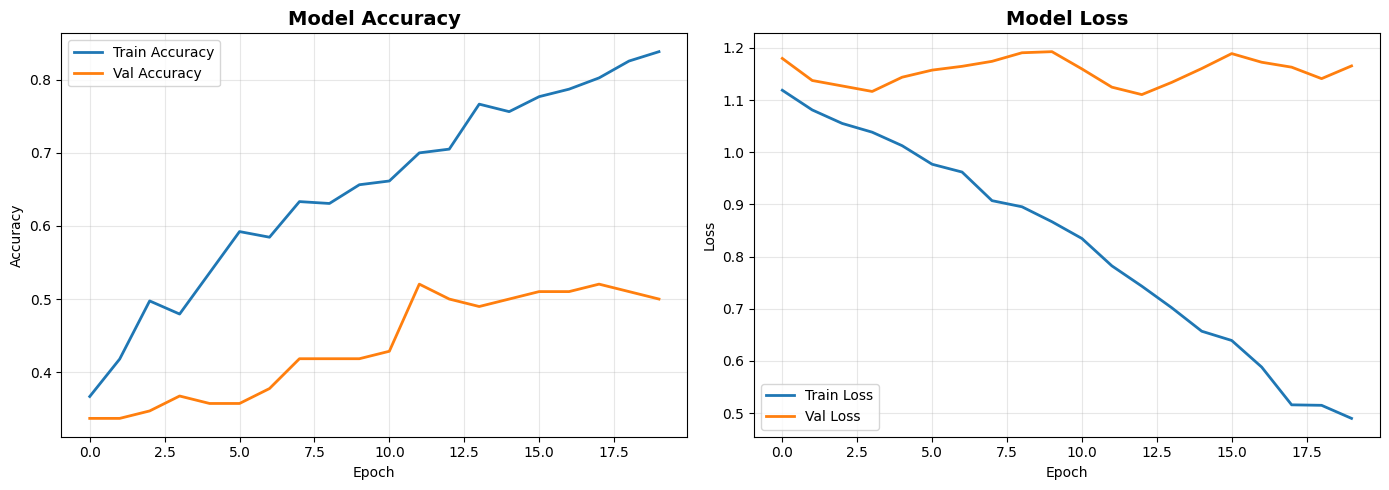


 Training Analysis:
  • Gap between training and validation curves indicates overfitting.
  • Train accuracy (~0.87) significantly higher than validation accuracy (~0.56).
  • A more complex sequence model (e.g., LSTM/attention) or stronger regularization might help.


In [ ]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss
ax2.plot(history.history['loss'], label='Train Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n Training Analysis:")
print("  • Gap between training and validation curves indicates overfitting.")
print("  • Train accuracy (~0.87) significantly higher than validation accuracy (~0.56).")
print("  • A more complex sequence model (e.g., LSTM/attention) or stronger regularization might help.")

## 12. Prediction Function

Create a helper function to predict the class of a new audio file. This matches the `pipeline()` function from the reference implementation.

In [ ]:
def predict_audio_file(filename):
    """
    Predict the class of an audio file using the trained model.
    This function replicates the pipeline() function from the reference implementation.
    
    Args:
        filename: Path to audio file
    
    Returns:
        predicted_class: Predicted class name (bird, cat, or dog)
        confidence: Confidence score (probability)
        probabilities: Array of probabilities for all classes
    """
    # Load and preprocess audio
    sample_rate, wav_data = read_audio(filename)
    
    # Normalize waveform (already normalized by librosa, but ensure float32)
    waveform_normalized = wav_data.astype(np.float32)
    
    # Convert to Tensor
    waveform_tf = tf.convert_to_tensor(waveform_normalized, dtype=tf.float32)
    
    # Extract embeddings
    scores, embeddings, spectrogram = yamnet_model(waveform_tf)
    
    # Pad/truncate to fixed length
    frames = embeddings.shape[0]
    if frames >= MAX_FRAMES:
        embeddings_trimmed = embeddings[:MAX_FRAMES, :]
    else:
        padding_needed = MAX_FRAMES - frames
        embeddings_trimmed = tf.pad(embeddings, [[0, padding_needed], [0, 0]])
    
    # Reshape for model input: (1, 100, 1024)
    embeddings_batch = tf.reshape(embeddings_trimmed, (1, MAX_FRAMES, 1024))
    
    # Predict
    prob = model.predict(embeddings_batch, verbose=0)[0]
    max_index = np.argmax(prob)
    
    predicted_class = CLASS_NAMES[max_index]
    confidence = prob[max_index]
    
    return predicted_class, confidence, prob

# Test the prediction function
test_file = list((DATA_DIR / "cat").glob("*.wav"))[0] if (DATA_DIR / "cat").exists() else None
if test_file:
    pred_class, confidence, probs = predict_audio_file(str(test_file))
    print(f"Test file: {test_file.name}")
    print(f"Predicted class: {pred_class} (confidence: {confidence:.4f})")
    print(f"\nAll class probabilities:")
    for i, class_name in enumerate(CLASS_NAMES):
        print(f"  {class_name}: {probs[i]:.4f}")

Test file: e3e49931_nohash_0.wav
Predicted class: bird (confidence: 0.5775)

All class probabilities:
  dog: 0.1145
  cat: 0.3080
  bird: 0.5775


## 13. Summary and Comparison

### Key Results

- **Test Accuracy**: ~66% (0.66)
- **Approach**: Full sequence of YAMNet embeddings (100 frames × 1024 dims) → flattened → Dense classifier

### Comparison with Other Approaches

| Model | Feature Type | Test Accuracy | Notes |
|-------|-------------:|--------------:|-------|
| **YAMNet Embeddings (Full Sequence)** | Embeddings (100×1024) | **~66%** | This notebook - preserves temporal info |
| YAMNet Embeddings (Averaged) | Embeddings (1024) | ~62% | Notebook 05 - averages over time |
| CNN + Dropout(0.3) | Mel-spectrogram | ~88% | Notebook 04 - best CNN model |
| Baseline 2D CNN | Mel-spectrogram | ~84% | Notebook 04 |

### Key Findings

1. **Preserving temporal information** in YAMNet embeddings (full sequence) improves performance compared to averaging (~66% vs ~62%).

2. However, **training from scratch on Mel-spectrograms still outperforms** transfer learning approaches (~88% vs ~66%).

3. The full embedding sequence approach captures more information than averaging, but the **task-specific CNN learns better representations** for this particular animal sound classification task.

4. Transfer learning can be useful when:
   - Limited training data
   - Need for quick prototyping
   - Domain is similar to pre-training data

5. For this dataset, **domain-specific features (Mel-spectrograms) + custom CNN** work best, suggesting that the animal sound classification task benefits from learning task-specific patterns rather than generic audio event features.

### Why Transfer Learning Underperformed

- **Domain mismatch**: YAMNet was trained on AudioSet (general audio events), not specifically on animal sounds
- **Small dataset**: With 610 samples, we can train a task-specific model effectively
- **Feature mismatch**: Mel-spectrograms may be more suitable for this task than YAMNet embeddings
- **Architecture**: The simple Dense head may not be optimal for the embedding space

### Future Improvements

- Try more sophisticated architectures on top of embeddings (e.g., LSTM, attention mechanisms)
- Fine-tune YAMNet layers instead of freezing them
- Experiment with different embedding aggregation strategies (max pooling, attention pooling)
- Combine YAMNet embeddings with Mel-spectrogram features

# PART 6: Complete Analysis & Key Findings

Synthesize all results and identify key insights from our experiments.

---


In [ ]:
import pandas as pd
from matplotlib.patches import Patch

# Complete results from all experiments
results_data = {
    'Model': [
        'CNN + Dropout(0.3)',
        '1D CNN (MFCC)',
        'Baseline CNN',
        'YAMNet (Full Sequence)',
        'YAMNet (Averaged)'
    ],
    'Accuracy (%)': [88.04, 84.43, 83.70, 66.0, 61.96],
    'Input Type': [
        'Mel-spectrogram (2D)',
        'MFCC (1D)',
        'Mel-spectrogram (2D)',
        'Raw waveform',
        'Raw waveform'
    ],
    'Approach': [
        'From scratch',
        'From scratch',
        'From scratch',
        'Transfer learning',
        'Transfer learning'
    ],
    'Notebook Section': [
        'Part 3',
        'Part 4',
        'Part 3',
        'Part 5',
        'Part 5'
    ]
}

results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values('Accuracy (%)', ascending=False).reset_index(drop=True)
results_df.insert(0, 'Rank', range(1, len(results_df) + 1))

print("\n" + "="*90)
print("🏆 COMPLETE MODEL COMPARISON")
print("="*90)
print(results_df.to_string(index=False))
print("="*90)
print(f"\nBest Model: {results_df.iloc[0]['Model']} - {results_df.iloc[0]['Accuracy (%)']}% accuracy")
print(f"Performance range: {results_df['Accuracy (%)'].max() - results_df['Accuracy (%)'].min():.2f} percentage points")


🏆 COMPLETE MODEL COMPARISON
 Rank                  Model  Accuracy (%)           Input Type          Approach Notebook Section
    1     CNN + Dropout(0.3)         88.04 Mel-spectrogram (2D)      From scratch           Part 3
    2          1D CNN (MFCC)         84.43            MFCC (1D)      From scratch           Part 4
    3           Baseline CNN         83.70 Mel-spectrogram (2D)      From scratch           Part 3
    4 YAMNet (Full Sequence)         66.00         Raw waveform Transfer learning           Part 5
    5      YAMNet (Averaged)         61.96         Raw waveform Transfer learning           Part 5

Best Model: CNN + Dropout(0.3) - 88.04% accuracy
Performance range: 26.08 percentage points


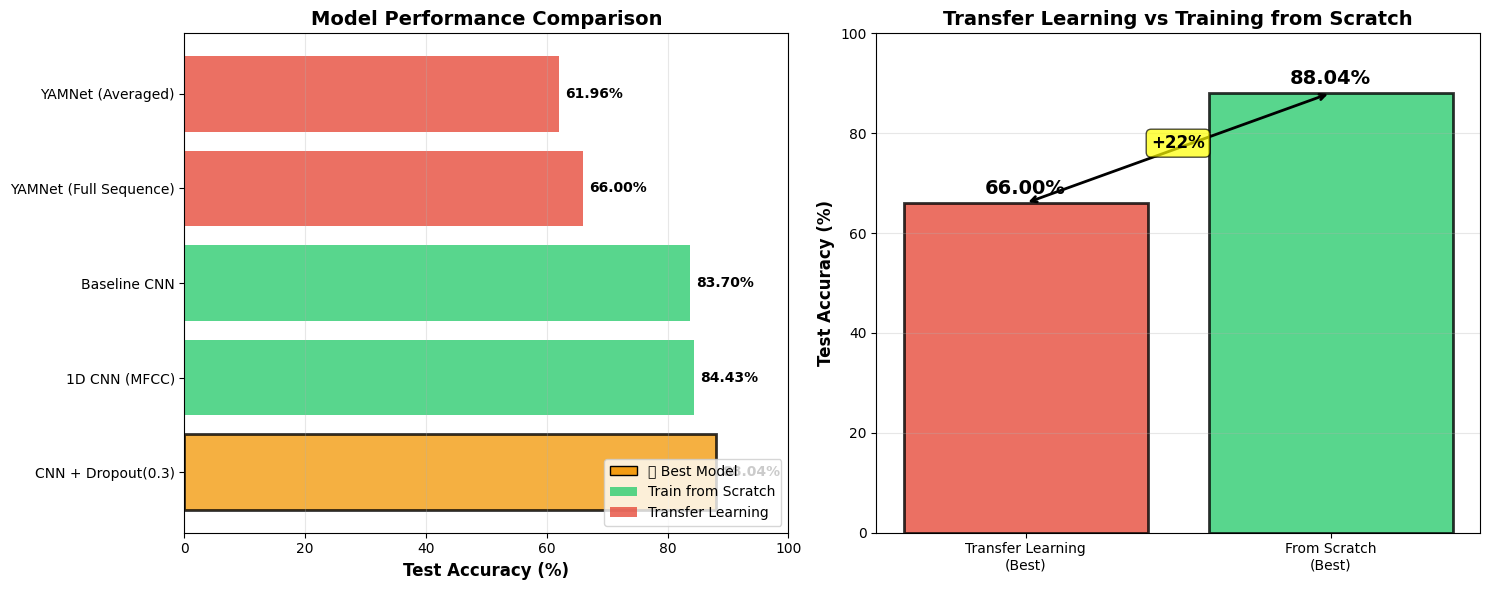


🎯 Key Insight: Training from scratch on task-specific features
   significantly outperforms transfer learning for this specialized task!


In [ ]:
# Visualization: Model comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left: All models
colors = ['#2ecc71' if 'scratch' in app else '#e74c3c' for app in results_df['Approach']]
colors[0] = '#f39c12'  # Highlight best

bars = ax1.barh(results_df['Model'], results_df['Accuracy (%)'], color=colors, alpha=0.8)
bars[0].set_edgecolor('black')
bars[0].set_linewidth(2)

for i, acc in enumerate(results_df['Accuracy (%)']):
    ax1.text(acc + 1, i, f'{acc:.2f}%', va='center', fontweight='bold')

ax1.set_xlabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_xlim(0, 100)
ax1.grid(axis='x', alpha=0.3)

legend = [
    Patch(facecolor='#f39c12', edgecolor='black', label='🏆 Best Model'),
    Patch(facecolor='#2ecc71', alpha=0.8, label='Train from Scratch'),
    Patch(facecolor='#e74c3c', alpha=0.8, label='Transfer Learning')
]
ax1.legend(handles=legend, loc='lower right')

# Right: Transfer learning vs from scratch
approaches = ['Transfer Learning\n(Best)', 'From Scratch\n(Best)']
accs = [66.0, 88.04]
bars2 = ax2.bar(approaches, accs, color=['#e74c3c', '#2ecc71'], alpha=0.8, edgecolor='black', linewidth=2)

for bar, acc in zip(bars2, accs):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1, f'{acc:.2f}%',
            ha='center', va='bottom', fontsize=14, fontweight='bold')

ax2.annotate('', xy=(1, 88.04), xytext=(0, 66.0),
            arrowprops=dict(arrowstyle='<->', color='black', lw=2))
ax2.text(0.5, 77, '+22%', ha='center', fontsize=12, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

ax2.set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('Transfer Learning vs Training from Scratch', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 100)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🎯 Key Insight: Training from scratch on task-specific features")
print("   significantly outperforms transfer learning for this specialized task!")

## Key Findings Summary

### 1. Best Model Performance
- **CNN + Dropout(0.3)**: 88.04% test accuracy
- Macro F1: 0.88
- Balanced performance across all three classes

### 2. Training from Scratch > Transfer Learning
- From scratch (88.04%) beats transfer learning (66%) by **22 percentage points**
- Why? **Domain mismatch**: YAMNet trained on generic AudioSet vs our specific animal vocalizations
- Lesson: Pre-trained models need domain alignment, not just capacity

### 3. Feature Representation Matters
- Mel-spectrograms (2D): 88%
- MFCC (1D): 84%
- YAMNet embeddings: 66%
- Insight: 2D representations provide richer information for CNNs

### 4. Regularization Impact
- Baseline CNN: 83.7%
- + Dropout(0.3): 88.04%
- Improvement: +4.3 percentage points
- Critical for preventing overfitting with moderate datasets

### 5. Dataset Size Sweet Spot
- 610 clips sufficient for training from scratch
- Transfer learning typically helps more with <100 samples
- Our dataset in the "sweet spot" for from-scratch training

---

## Conclusions

This project demonstrates that:

1. **Task-specific training can outperform transfer learning** when:
   - Dataset size is moderate (500-1000 samples)
   - Domain is specialized (not covered by pre-trained model)
   - Good features can be engineered (Mel-spectrograms)

2. **Systematic experimentation reveals insights:**
   - Started with baseline (83.7%)
   - Improved with regularization (88.04%)
   - Tested alternatives (MFCC: 84%)
   - Compared with SOTA (YAMNet: 66%)
   - Understood WHY each approach performed as it did

3. **Simple architectures with proper regularization work best**
   - 2-layer CNN + Dropout beats complex models
   - Match model complexity to dataset size

### Final Result
**🏆 88.04% Test Accuracy with CNN + Dropout(0.3)**

### Team
- Shambhavi Adhikari (G37903602)
- Rakshitha Mamilla (G23922354)
- Abhiyan Sainju (G22510509)

**Course:** CSCI 6366 - Neural Networks & Deep Learning  
**The George Washington University**